# **Pablo Santa Cruz Sánchez - 100428988@alumnos.uc3m.es**

# Semantic Graph Analysis
---

Date: Nov, 30, 2023

Authors: Jesús Cid-Sueiro (jcid@ing.uc3m.es)
         Jerónimo Arenas-García (jarenas@ing.uc3m.es)

Version 1.0



**Notebook format**

In [ ]:
#To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

**Libraries**

In [ ]:
import sys
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as scsp
import seaborn as sns
from collections import Counter

# Common imports
# from termcolor import colored
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [ ]:
# If fa2 is available, it is imported
try:
    from fa2 import ForceAtlas2
    is_fa2 = True

except ModuleNotFoundError:
    if sys.version_info < (3, 9):
        %pip install fa2
        from fa2 import ForceAtlas2
        is_fa2 = True
    else:
        print("WARNING: At the time of writing this notebook, fa2 is not available for python 3.9 or higher")
        print("You can try 'pip install fa2', but it will likely fail")
        print("This is not a major issue. Some cells below that use Fa2 will not be executed, you can run the notebook anyway")
        is_fa2 = False

You can try 'pip install fa2', but it will likely fail
This is not a major issue. Some cells below that use Fa2 will not be executed, you can run the notebook anyway


In [ ]:
# Check if the notebook is running in Google colab
try:
    from google.colab import drive
    in_colab = True
except:
    in_colab = False

if in_colab:
    # For colab runners
    # For fancy table Display
    %load_ext google.colab.data_table
    drive.mount("/content/drive")

    # Set you local folder here
    local_folder = pathlib.Path('/content/drive/My Drive/')
else:
    # For local running
    local_folder = pathlib.Path('.')

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Embeddings

Classical and modern natural language processing techniques provide several methods to map text documents to an **embedding** space: TF-IDF representations, topic models, transformers, etc.

These embedding spaces are also named **semantic spaces**, because the document mapping is expected to project documents that are semantically similar into similar vector representations, and unrelated documents to points that are far apart.

In this notebook we will use **similarity measures** defined in the semantic space, to construct graphs connecting documents in a corpus. We will exploit the graph structure to solve further tasks like communitty detection or the identification of particularly relevant documents.

### 1.1. Dataset

Our data source will be a corpus of research projects from the NSF

In [ ]:
path2data = local_folder / 'datasets' / 'NSF_df_35topics.xlsx'

NSF_df_all = pd.read_excel(path2data)
corpus_size = len(NSF_df_all)
print(f"Original dataset contains {corpus_size} documents")
NSF_df_all.head()

Original dataset contains 35691 documents


,project_code,title,year,budget,institution,zipcode,state,lemmas,nlemmas,clean_lemmas,LDA_35,main_topic_35
0,1700003,Partial Differential Equations in Several Comp...,2017,201000,University of Notre Dame,465565708,IN,complex analysis variable play special role ma...,140,complex variable play special mathematic mathe...,"[(4, 0.011100946833056041), (22, 0.10280974848...",Mathematics
1,1700009,Spectral Properties of Random Band Matrices an...,2017,119998,Princeton University,085442020,NJ,research project intertwine mathematical physi...,137,project intertwine mathematical physics relate...,"[(15, 0.26245343186564934), (22, 0.03159154401...",Mathematics
2,1700011,Pluripotential Theory and Applications to Comp...,2017,156000,Syracuse University,132441200,NY,research project area complex analysis complex...,234,project area complex complex geometry potentia...,"[(29, 0.9347396967444226), (31, 0.039623741880...",Mathematics
3,1700014,Nanoscale Phase Transition in Free-Standing Di...,2017,396171,Iowa State University,500112207,IA,non technical description capacitor essential ...,184,non technical description capacitor essential ...,"[(1, 0.02061130940053745), (13, 0.193800868364...",Material Engineering and production
4,1700021,K-Theory of Operator Algebras and Its Applicat...,2017,223000,Texas A&M University,778454375,TX,classical geometry study geometric object coor...,132,classical geometry study geometric object coor...,"[(2, 0.013963760058225928), (6, 0.013351655243...",Mathematics


Documents contain one or several topic labels in column `main_topic_35`.

In [ ]:
print(set(NSF_df_all['main_topic_35']))

{'Astrophysics', 'Machine Learning', 'Climate change', 'Image processing', 'Social studies', 'Language Technologies', 'Manufacturing', 'Robotics', 'Disaster Prevention and Control', 'Chemistry', 'Material Engineering and production', 'Urban projects for local communities', 'Computer Science, Cloud Computing', 'Material Engineering', 'Cybersecurity', 'Microbiology', 'Geology', 'Quantum Physics', 'Electronics and Optics', 'Sustainability, Environment', 'Biological Evolution', 'Wireless Communications, Internet', 'Particle physics', 'Garbage topic', 'Garbage topic (Infrastructure)', 'Economy and Finances', 'Cellular Neurology', 'Health', 'Genetics', 'Energy, Renewable energy', 'Learning and Teaching technologies', 'Mathematics', 'Environment, biodiversity', 'Fluid Physics'}


We will remove those documents with a label `Garbage topic`, which have no clear thematic content.

In [ ]:
# Remove garbage topics
NSF_df_all = NSF_df_all[NSF_df_all['main_topic_35']!='Garbage topic']
corpus_size = len(NSF_df_all)
print(f"Clean dataset contains {corpus_size} documents")

Clean dataset contains 32462 documents


In order to keep a modurate computational load in all steps in this notebook, we will start by selecting at random sample of

In [ ]:
# Take a sample of documents
n_docs = 1000

print(f"{n_docs} documents")

1000 documents


from the original source.

In [ ]:
# Take a sample of documents
sample_factor = n_docs / corpus_size
# Select a random sample with n_docs length from dataset
NSF_df = NSF_df_all.sample(n_docs, random_state=0)
print(f"Dataset reduced to {n_docs} documents")
print("Sample documents:")
NSF_df.head()

Dataset reduced to 1000 documents
Sample documents:


,project_code,title,year,budget,institution,zipcode,state,lemmas,nlemmas,clean_lemmas,LDA_35,main_topic_35
8393,1748493,Workshop on Future Directions for Algorithms i...,2017,98936,Carnegie-Mellon University,152133815,PA,computation essential progress biology importa...,155,computation essential progress biology importa...,"[(6, 0.334499493727768), (16, 0.14659588375997...",Machine Learning
12903,1806639,Searches for New Phenomena at the Energy Frontier,2018,900000,Northern Illinois University,601152828,IL,award provide support Northern Illinois Univer...,234,award provide support northern illinois work a...,"[(19, 0.06077387264038543), (21, 0.87164872079...",Particle physics
4468,1724462,Long Term Urban Change in Response to Social C...,2017,187150,University of Wisconsin-Madison,537151218,WI,support National Science Foundation Sarah Clay...,195,support national foundation sarah clayton coll...,"[(2, 0.05369275955261192), (10, 0.084926647124...","Environment, biodiversity"
13890,1811770,EAGER: Nature of the Pre-chemistry Ensemble in...,2018,299499,CUNY City College,100319101,NY,Kinases biological molecule modify rate specif...,256,kinases biological molecule modify rate chemic...,"[(1, 0.011731656602373729), (2, 0.038676554709...",Genetics
26723,1914840,Collaborative Research: Assessment of Student ...,2019,353417,University of Colorado at Boulder,803031058,CO,support NSF Improving Undergraduate STEM Educa...,178,support nsf improving program human resources ...,"[(6, 0.0832362269209068), (21, 0.2510231935876...",Learning and Teaching technologies


### 1.2. LDA Embedding

Now we will extract the embedding matrix of the selected documents, that is contained in colummn `LDA_35` of the dataframe. Each row contains the embedding of the corresponding document in the selected dataframe, computed using a LDA algorithm for topic modelling with 35 topics.

In [ ]:
from gensim.matutils import corpus2csc
from ast import literal_eval
# literal_eval converts the string with the embedding to its correct corresponding data type (tuple list)
X = [literal_eval(el) for el in NSF_df['LDA_35'].values.tolist()]
# Now we convert X into a sparse matrix (compressed) where each document only has its topic representation (only most important topics)
X = corpus2csc(X).T
n_topics = X.shape[1]

print(f"Number of topics: {n_topics}")
print(f"X: sparse matrix with {X.nnz} nonzero values out of {n_docs * n_topics}")
print(X.shape)

Number of topics: 35
X: sparse matrix with 6640 nonzero values out of 35000
(1000, 35)


Just as an example `X[0, :]` contains the representation of document 0 in the semantic space:

In [ ]:
n = 0
print(f"Document: ")
print(f"Project code: {NSF_df.iloc[n].project_code}")
print(f"Title:        {NSF_df.iloc[n].title}")
print(f"Embedding:")
# Showing the most important topics for document 0
print(X[n, :])

Document: 
Project code: 1748493
Title:        Workshop on Future Directions for Algorithms in Biology
Embedding:
  (0, 6)	0.334499493727768
  (0, 16)	0.1465958837599702
  (0, 24)	0.06123200769067862
  (0, 25)	0.04494988112338156
  (0, 30)	0.062254564692272724
  (0, 33)	0.32221264527202664


Note that the embedding is shown in sparse format, showing the non-zero values only. The proportion of zero entries is

In [ ]:
print(f"{(1 - X.nnz / n_docs / n_topics) * 100:.2f} % ")

81.03 % 


All other entries are values in $[0, 1]$. Since the embedding space is probabilistic the row vectors should sum up to one. However, we can check that this is no exactly the case: the average row sum is

In [ ]:
print(f"Average row sum: {np.mean(X.sum(axis=1).T)}")

Average row sum: 0.9727200198511103


This is because small nonzero values in the embedding vectors have been truncated to zero. We will renormalize the input to forze probabilistic representations.

In [ ]:
# Normalization:
X = scsp.csr_matrix(X / np.sum(X, axis=1))
print(f"Average row sum: {np.mean(X.sum(axis=1).T)}")

Average row sum: 1.0


### 1.3. Embedding distribution

The distribution of the normalized nonzero values in ${\bf X}$ is shown in the figure:

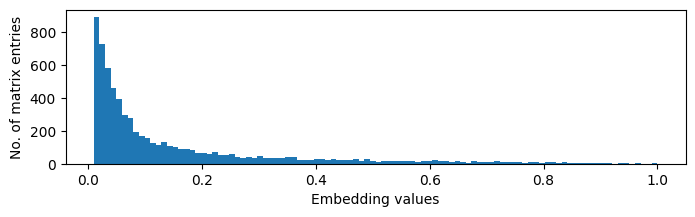

In [ ]:
plt.figure(figsize=(8, 2))
plt.hist(X.data, bins=100)
plt.xlabel('Embedding values')
plt.ylabel('No. of matrix entries')
plt.show()

## 2. Semantic Similarity Measures.

In order to construct a **semantic graph** from a collection of document embeddings, a similary measure between two embeddings, ${\bf x}$ and ${\bf y}$, is required.

In this section we will propose several measures for arbitrary embeddings and, also, specific measures for probabilistic embeddings


### 2.1. Similarity between probabilistic embeddings

Assume that ${\bf x}$ and ${\bf y}$ are probabilistic embeddings, that is, vectors whose components take values in $[0, 1$ and sum up to one. Several similarity measures have been proposed:

* **Jensen-Shannon** (JS): It is defined as
$$
s_{\rm JS}({\bf x}, {\bf y})= 1 - d_{\rm JS}({\bf x}, {\bf y})
$$
where $d_{\rm JS}$ is the [Jensen-Shannon distance](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), given by
$$
d_{\rm JS}({\bf x}, {\bf y}) = \frac12 \left({\bf x} \log_2 \left(\frac{2{\bf x}}{{\bf x} + {\bf y}}\right)
                                           + {\bf y} \log_2 \left(\frac{2{\bf y}}{{\bf x} + {\bf y}}\right)\right)
$$
where, with some abuse of notation, the logarithm and the ratio of vectors must be computed component-wise. It is not difficult to see that the JS similarity is bounded by
$$
0 \le s_{\rm JS}({\bf x}, {\bf y}) \le 1
$$

* **[Bhattacharyya Coefficient](https://en.wikipedia.org/wiki/Bhattacharyya_distance#Bhattacharyya_coefficient)** (BC):
$$
s_{\rm BC}({\bf x}, {\bf y}) = \sqrt{{\bf x}}^\intercal \sqrt{{\bf y}}
$$
where the square roots must be computed component-wise. The BC coefficient is bounded by
$$
0 \le s_{\rm BC}({\bf x}, {\bf y}) \le 1
$$


### 2.2. Similarity between arbitrary embeddings

For generic embeddings (either probabilistic or not), other similarity measures can be defined:

* **Cosine similarity**: It is given by
$$
s_{\rm CS}({\bf x}, {\bf y})
    = \frac{{\bf x}^\intercal {\bf y}}
           {\|{\bf x}\| \|{\bf y}\|}
$$
The CS similarity is bounded by
$$
-1 \le s_{\rm CS}({\bf x}, {\bf y}) \le 1
$$

* **Distance-based similarities**: we can transform any distance metric $d({\bf x}, {\bf y})$ into a similarity measure by exponentiation:
$$
s({\bf x}, {\bf y})= \exp\left(- \alpha · d({\bf x}, {\bf y})\right)
$$
which maps non-negative distances into $[0, 1]$ with $s({\bf x}, {\bf y}) = 1$ for $d({\bf x}, {\bf y})=0$. Parameter $\alpha$ is a scaling factor.

  Note that, if $d$ is a distance metric, it satisfies the triangular inequality, i.e. for any ${\bf x}$, ${\bf y}$ and ${\bf z}$,
  $$
  d({\bf x}, {\bf z}) \le d({\bf x}, {\bf y}) + d({\bf y}, {\bf z})
  $$
  which implies
  \begin{align}
  s({\bf x}, {\bf z}) &=   \exp\left(- \alpha d({\bf x}, {\bf z})\right) \\
                    &\ge \exp\left(- \alpha d({\bf x}, {\bf y}) - \alpha d({\bf y},   {\bf z})\right) \\
                    &= s({\bf x}, {\bf y}) \cdot s({\bf y}, {\bf z})
  \end{align}

  Therefore, the similarity between two documens is lower-bounded by the product of the similarities at any path connecting them.

---
**Exercise 1**: Take the document at position

In [ ]:
# If two documents have the exact opossite semantic meaning, its similarity value usiing Cosine Similarity would be -1. If two documents dont have any relationship between each other, the distance would be 0.
i = 0

in the dataframe. Determine the most and the least similar documents in the dataframe, according to the BC similarity measure. To do so

 * Compute array BC containing the Bhattacharya Coefficient bettween this doc and all docs in the dataframe

In [ ]:
xi = X[i, :].T
# You can do the computation in a single line, multiplying sqrt(X) times xi.
BC = np.sqrt(X.dot(xi))
# This may be useful to convert your solution into a 1D array.
BC = BC.toarray().T[0]

 * Compute the indices of the least similar and the most similar documents in the dataframe (excluding the document itself). Maybe you can use `numpy` methods `argmin` and `argmax`.

In [ ]:
imin = np.argmin(BC)

BC_i = BC
# In order to exclude the comparing document we make BC_i and BC to point the same point of memory and we put the comparing number value to 0
# That way it can never be the most similar document (since we are looking for similarity values between 0 and 1)
BC_i[i] = 0

imax = np.argmax(BC)


We can print the position, project code and title of the test document, its most and its least similar documents, and also its corresponding BC values

In [ ]:
print("Test document: ")
print(f"-- Position: {i}")
print(f"-- Project code: {NSF_df.iloc[i].project_code}")
print(f"-- Title:        {NSF_df.iloc[i].title}\n")
# print(f"-- Clean lemmas: {NSF_df.iloc[i].clean_lemmas}")

print("Most similar document: ")
print(f"-- Position: {imax}")
print(f"-- Project code: {NSF_df.iloc[imax].project_code}")
print(f"-- Title:        {NSF_df.iloc[imax].title}")
#print(f"-- Clean lemmas: {NSF_df.iloc[imax].clean_lemmas}")
print(f"--BC: {BC_i[imax]}\n")

print("Least similar document: ")
print(f"-- Position: {imin}")
print(f"-- Project code: {NSF_df.iloc[imin].project_code}")
print(f"-- Title:        {NSF_df.iloc[imin].title}")
print(f"-- BC: {BC_i[imin]}")
#print(f"-- Clean lemmas: {NSF_df.iloc[imin].clean_lemmas}")

Test document: 
-- Position: 0
-- Project code: 1748493
-- Title:        Workshop on Future Directions for Algorithms in Biology

Most similar document: 
-- Position: 842
-- Project code: 1913149
-- Title:        Statistical Learning Problems with Complex Stochastic Models
--BC: 0.5593031102879528

Least similar document: 
-- Position: 7
-- Project code: 1725919
-- Title:        MRI: Acquisition of a 500 MHz Nuclear Magnetic Resonance (NMR) Spectrometer with Cryoprobe
-- BC: 0.0


### 2.3 Similarity Matrix

To construct the similarity graph, we will compute a similarity matrix ${\bf S}$ such that $S_{ij}$ contains the similarity between the $i$-th document and the $j$-th document.

We will use the BC similarity measure, because it allows a block computation of the matrix as
\begin{align}
{\bf S} = \sqrt{{\bf X}} \sqrt{{\bf X}^T}
\end{align}
where the square roots are computed component-wise.

---
**Exercise 2**: Compute the similarity matrix `S` based on the BC and print:
  * The number of nonzero components in `S` (hint: you can use method `nnz` from `numpy`)
  * The proportion of nonzero components in `S`

In [ ]:
# Compute BC similarity
# <SOL>
# We use matrix multiplication to make S
S = np.sqrt(X) @ np.sqrt(X).T
nonzero_components = S.nnz
total_components = S.shape[0] * S.shape[1]
proportion_nonzero = nonzero_components / total_components
print("Number of non-zero components in S:", nonzero_components)
print("Proportion of non-zero components in S:", proportion_nonzero)
# </SOL>

Number of non-zero components in S: 742020
Proportion of non-zero components in S: 0.74202


Note that, due to the sparse nature of the input matrix, the similarity matrix contains many zeros, which allows a sparse representation. In adition, since the similarity matrix is symmetric, and all diagonal values are unity, we can keep the upper triangular part of the matrix only, to save memory.

---
**Exercise 3**: Using method `triu`from `scipy.sparse`, remove the diagonal and lower triangular part of the similarity matrix `S` based on the BC and print. Save the result in `S` and print the number of nonzero components.

In [ ]:
from scipy.sparse import triu
# Matrix is symmetric. Keep only upper triangular part
S = triu(S, k=1)
nonzero_components_S = S.nnz
print('Number of non-zero components in S:', nonzero_components_S)

Number of non-zero components in S: 370510


Note that saving memory is important here: with a 8-Byte representation (float 64) for each similarity value, a dense similarity matrix of a 35.000 document matrix would have required arount 5 GB (exploiting symmetry).

## 3. The semantic graph

### 3.1. Graph construction

We will call **semantic graph** to the weighted graph given by:

   * **Nodes**: the documents in the corpus
   * **Edges**: links connecting pairs of documents with nonzero similarity and  
   * **Weights**: the similarity values

Therefore, the semantic graph is determined by the documents and the similarity matrix.

The graph is **undirected**, because the similarity is a symmetric measure ($s_{\rm BC}({\bf x}, {\bf y}) = s_{\rm BC}({\bf y}, {\bf x})$)

---
**Exercise 4**: Print the number of nodes, the number of edges and the average number of edges per node in the semantic graph:

In [ ]:
n_nodes = S.shape[0]
n_edges = S.nnz
n_edges_per_node = n_edges / n_nodes

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Number of edges per node: {n_edges_per_node}")


Number of nodes: 1000
Number of edges: 370510
Number of edges per node: 370.51


Note that, despite ${\bf S}$ is sparse, the number of edges per node is quite large. We may have several reasons to keep a limited number of edges:

 * Our interest is usually focused in the relations between similar documents. Low similarity values are usually not informative for the analysis.
 * If the input matrix is dense of with low sparsity, the similarity matrix can be dense or almost dense, causing memory problems

For this reason, imposing a threshold on the similarity values, keeping only the information about pairs of documents with similarity above the threshold, may be recommended

Note that removing a link is not necessarily equivalent to assign a zero value to it. For instance, if the relation
\begin{align}
s({\bf x}, {\bf z}) &= s({\bf x}, {\bf y}) \cdot s({\bf y}, {\bf z})
\end{align}
discussed above is satisfied, even though the edge $({\bf x}, {\bf z})$ was removed, a lower bound of the similarity can be restored from a path $s({\bf x}, {\bf y}, {\bf z})$. Thus, the semantic graph may preserve relevant document connections even after thresholding.

A quick inspection of the histogram of similarity values shows that even a moderate threshold at 0.5 woud remove a significant number of edges

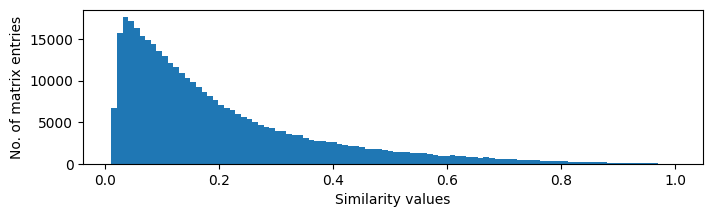

In [ ]:
plt.figure(figsize=(8, 2))
plt.hist(S.data, bins=100)
plt.xlabel('Similarity values')
plt.ylabel('No. of matrix entries')
plt.show()

---
**Exercise 5**: Apply a threshold to ${\bf S}$ in order to get a subgraph with an average of 10 edges per node. There are several ways to do this. For instance, you can try the following:
  1. Compute the target number of edges, `n_edges`
  2. Sort the similarity values in descending order (`numpy.sort` over the similarity values in `S.data`may help)
  3. Take the similarity value in the `n_edges` position as the threshold value, `thr`
  4. Apply the threshold to the similarity matrix (over `S.data`)
  5. Remove zeros from `S`(using `eliminate_zeros()` method)

In [ ]:
# Set average number of edges per node
n_edges_per_node = 10

# Compute threshold to get the target number of edges
# <SOL>
# Here we calculate the number of edges that we will have as target for our graph
target_edges = n_edges_per_node * n_nodes
# Next, we sort the similarity values from highest to lowest
sorted_similarity_values = np.sort(S.data)[::-1]
# Now we get the index of the lowest similarity edge we will add to our graph
threshold_index = target_edges - 1
# And we use it to get the threshold (value) from where all lower similarity value edges will be removed
thr = sorted_similarity_values[threshold_index]
# </SOL>

# Apply the threshold to similarity matrix
# <SOL>
# To do it, we put the values lower than the threshold to 0 and then we remove those values
S.data[S.data < thr] = 0
S.eliminate_zeros()
# </SOL>

print(f"Threshold: {thr}")
print(f"Number of edges: {n_edges}")
print('Estimated number of links in full corpus:', len(S.data)/2/sample_factor**2)

Threshold: 0.6573561176356922
Number of edges: 370510
Estimated number of links in full corpus: 5268907.22


Now, we are ready to analyze the graph structure. To do so, we will use the [networkx](https://networkx.org/documentation/stable/index.html) library, by creating a graph object from the similarity matrix.

In [ ]:
# ##################################
# Transform graph to networkx format

# Convert matrix into graph
# WARNING: In Google Colab, you might need to use from_scipy_sparse_matrix
if in_colab:
    G = nx.from_scipy_sparse_array(S)
else:
    G = nx.from_scipy_sparse_array(S)

### 3.2. Graph visualization: layout algorithm

We can visualize the graph in the standard way, by plotting  nodes are poins in a plane and drawing lines connecting nodes with an edge.

Positioning the nodes in the planes is not a trivial issue. A **layout algorithm** is an algorithm that, given the graph matrix, determines the position of each node in the plane (or in a 3D space) for visualization purposes.

#### Random layout

It is easy to verify that a random layout does not provide a meaningful visualization:


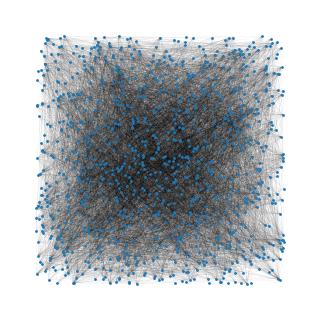

In [ ]:
# ########################
# Testing a random  layout

positions = nx.drawing.layout.random_layout(G)
plt.figure(figsize=(3,3))
nx.draw(G, positions, node_size=1, width=0.02)

In general, layout algorithms search a 2D or 3D data projection in such a way that strongly connected documents (i.e. very similar documents) are close to each other, and disconnected or weakly connected nodes are far apart. There is not a unique way to do that: different algorithms produce quite different layouts, and even the same algorithm may generate different projections depending on the initial position of the nodes (that are usually modified iteratively).

[Force-directed algorithms](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) find the layout by moving nodes iteratively according to attractive or repulsive forzes defined by the proximity of other nodes. We will explore two of them:


#### Fruchterman-Reingold

For networks with small or moderate size, the **Fruchterman-Reingold** (FR) force-directed can be used. It considers two forces:

  * A **repulsive (anti-gravity) force** between any pair of nodes.
  * An **attractive force** between connected nodes. That is, edges behave as springs attracting the terminal nodes.
  
The algorithm moves nodes iteratively according to these forzes, and stops when the positions are close to an equilibrium.

Procedure:

___
   1. For each node $n$ at position ${\bf x}_n$ do:
   
      * For each node $m$ at position ${\bf x}_n$, compute repulsive force:
          \begin{align}
          {\bf r}_{nm} = \frac{k^2}{d({\bf x}_m, {\bf x}_n)}({\bf x}_n - {\bf x}_m)
          \end{align}
      * For each neighbour node $m \in {\cal N}(n)$, compute attrative force:
      \begin{align}
      {\bf a}_{nm} = \frac{S_{mn} d^2({\bf x}_m, {\bf x}_n)}{k }({\bf x}_m - {\bf x}_n)
       \end{align}
      * Sum all force vectors: \begin{align}
      {\bf f}_n = \sum_{m} {\bf r}_{nm} + \sum_{m \in {\cal N}(n)} {\bf a}_{nm}
      \end{align}
      

   2. Move node $m$ in the direction of the force: $${\bf x}_n' = {\bf x}_n + \gamma \cdot {\bf f}_n, \qquad \gamma \in [0,1]$$.
---

Here, $S_{mn}$ is the $(m,n)$-entry of the graph matrix ${\bf S}$ and $d({\bf x}, {\bf y})$ is the euclidean distance between the positions of nodes $n$ and $m$.

You can check the `Networkx` documentation to read about the free parameters of the [spring_layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html) method implementing the algorithm.

---
**Exercise 6**: Apply the FR algorithm to the semantic graph over 50 iterations. Use `seed=0`. Save the node locations in variable `positions` and plot the graph.


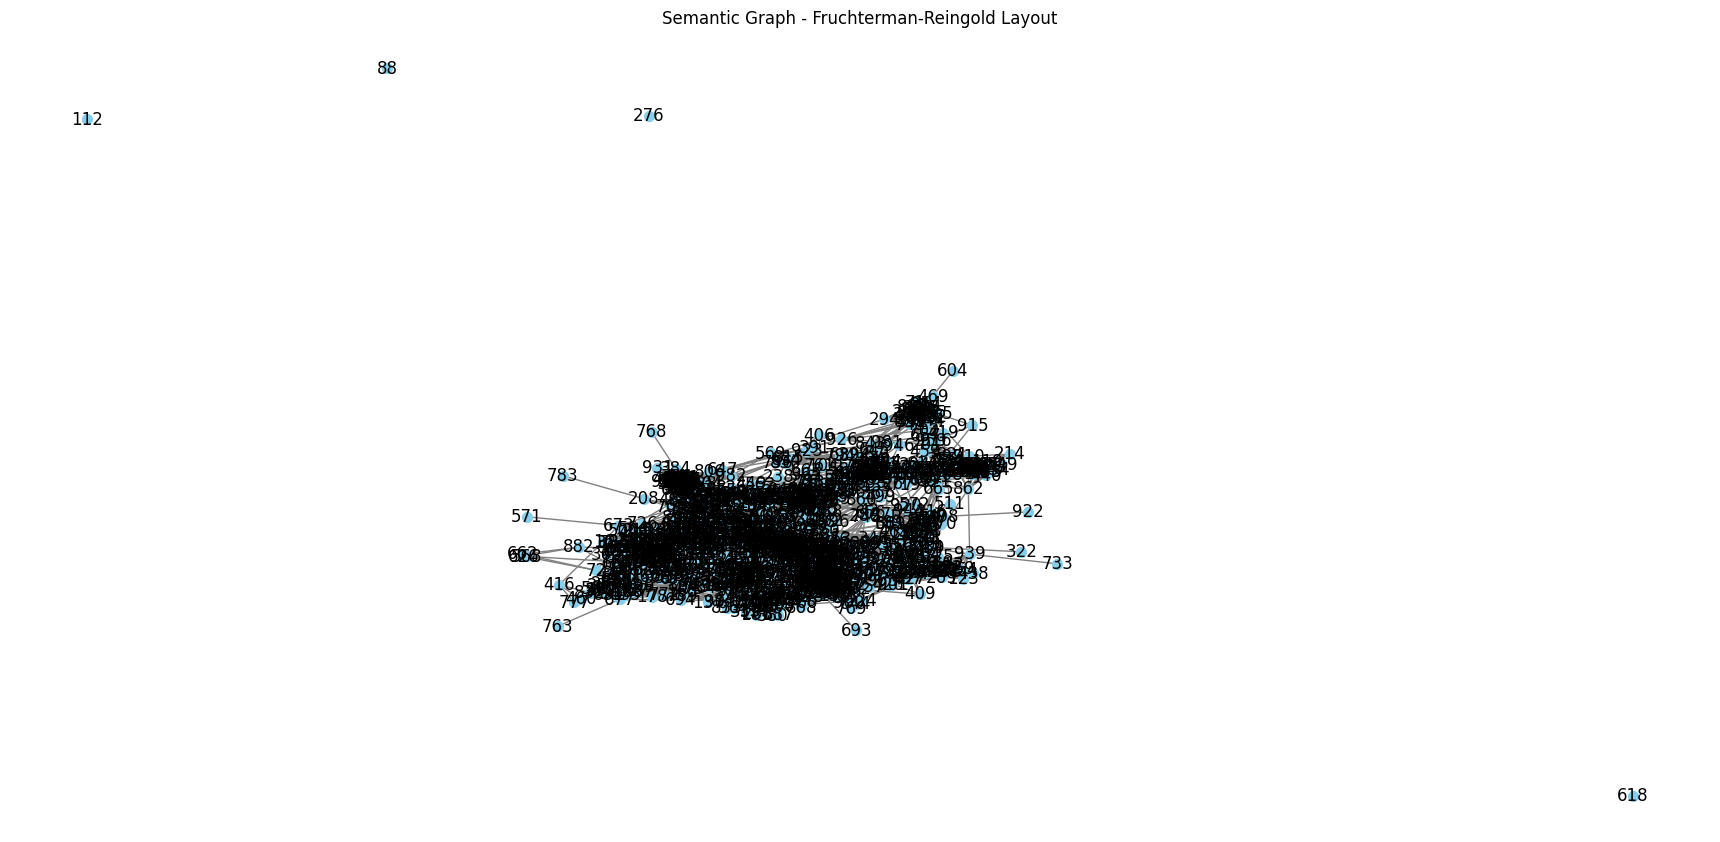

In [ ]:
# Compute positions
# <SOL>
positions = nx.spring_layout(G, iterations=50, seed=0)
# </SOL>

# Draw graph
# <SOL>
plt.figure(figsize=(17, 8))
nx.draw(G, pos=positions, with_labels=True, node_size=50, node_color='skyblue', edge_color='gray')
plt.title("Semantic Graph - Fruchterman-Reingold Layout")
plt.show()
# </SOL>

As you can probably see, the graph may contain nodes or groups of nodes that are isolated from the rest of the graph. This is a side effect of the thresholding: some nodes with low similarity values relative to all other nodes, get isolated in the graph and expelled from the core of the graph by the repulsive forces.

We can focus the attention in the largest connected component of the graph:

---
**Exercise 7**: Extract the largest connected component  (LCC) from the graph, save it in subgraph `G_lcc` and apply the FR layout. You can proceed as follows:

  1. Compute the nodes of the LCC using [connected_components](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html#networkx.algorithms.components.connected_components) method.
  2. Using method [subgraph](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html), copy the LCC subgraph into variable `G_lcc`.
  3. Draw subgraph `G_lcc`
  

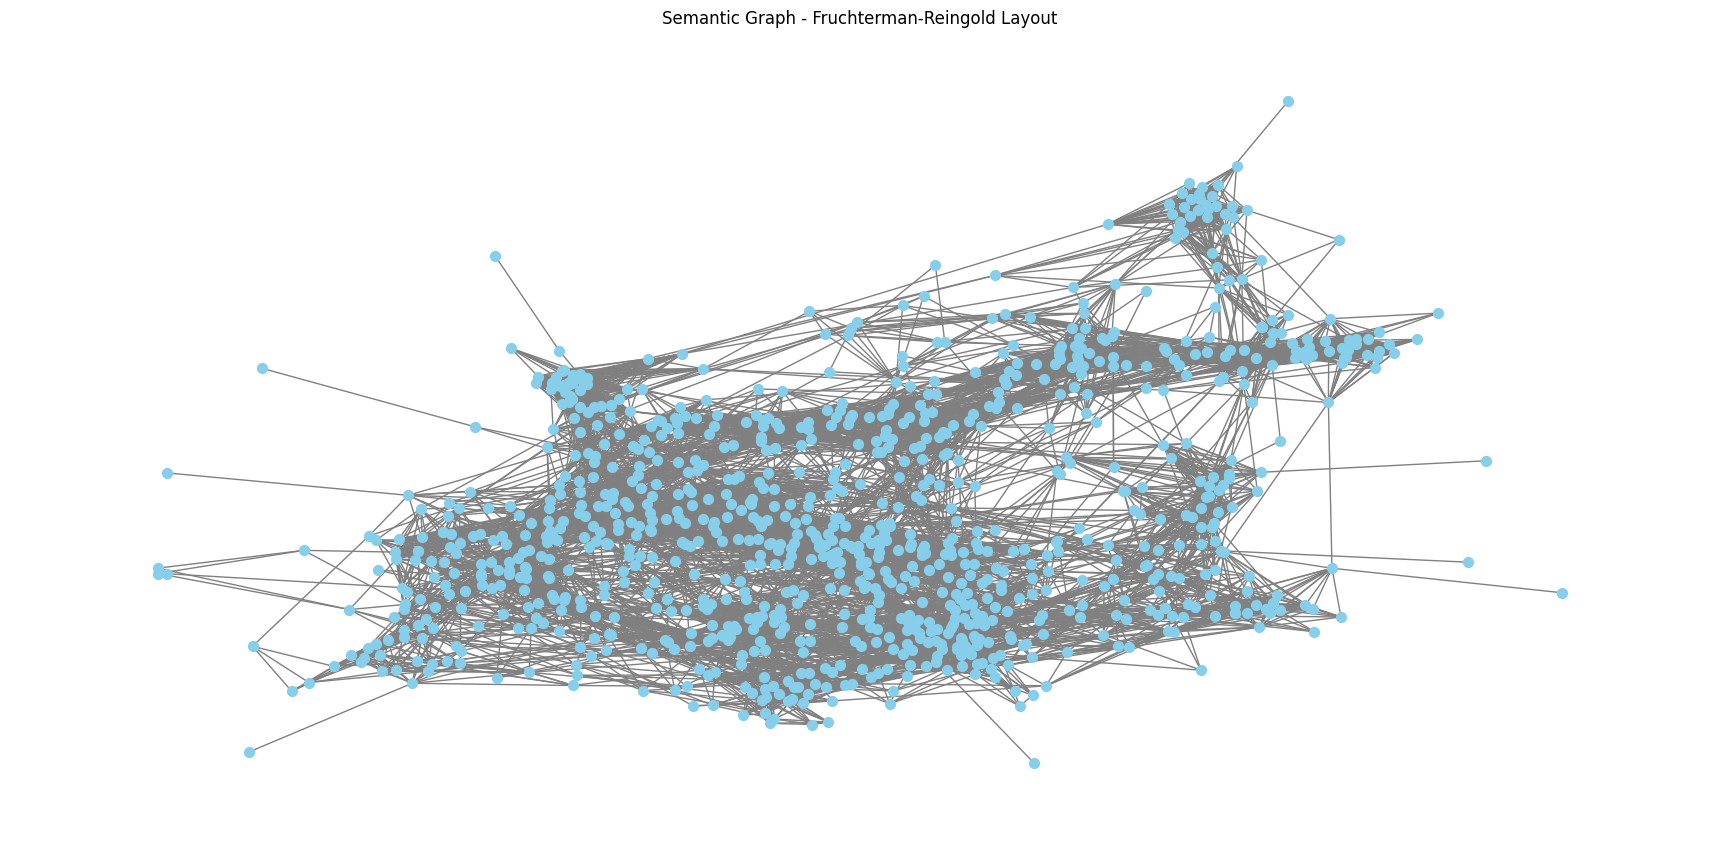

In [ ]:
# <SOL>
connected_components = nx.connected_components(G)
largest_connected_component_nodes = max(connected_components, key=len)
G_lcc = G.subgraph(largest_connected_component_nodes)
positions_lcc = nx.spring_layout(G_lcc, seed=0)

plt.figure(figsize=(17, 8))
nx.draw(G_lcc, pos=positions, with_labels=False, node_size=50, node_color='skyblue', edge_color='gray')
plt.title("Semantic Graph - Fruchterman-Reingold Layout")
plt.show()
# </SOL>

#### Force Atlas

There are many other layout algorithms. One major inconvenient of FR is that is does not scale well to graphs with many nodes and edges. A good alternative for large graphs is the **Force Atlas** algorithm, which finds a trade-off between the quality of the graph and the convergence speed (you can check [[Jacomy, 2014]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0098679#s2) to know more details about the algorithm).

---
**Exercise 8**: Apply the force atlas algorithm using class `ForceAtlas2` from module `fa2`. Use `gravity=50` and 200 iterations. Draw the resulting layout.


In [ ]:
# #####################################################################################
# WARNING: IGNORE THIS EXERCISE IF fa2 COULD NOT BE IMPORTED (i.e., if is_fa2 == False)
#          (fa2 will likely not work in python > 3.8)
# #####################################################################################

if is_fa2:
    # Compute positions using layout algorithm
    gravity = 50

    # Create layout object
    # <SOL>
    # </SOL>

    # This is a hack to avoid an execution error depending on the version of networkx. You can
    # simply ignore but not remove it
    if not hasattr(nx, "to_scipy_sparse_matrix"):
        def to_scipy_sparse_matrix(G, dtype='f', format='lil'):
            return nx.to_scipy_sparse_array(G_lcc)
    nx.to_scipy_sparse_matrix = to_scipy_sparse_matrix

    # Compute node positions using forceatlas2_networkx_layout method.
    # positions = <FILL IN>

    # Draw graph
    # <SOL>
    # </SOL>
else:
  print(is_fa2)


False


## 4. Graph analysis: community detection algorithms

### 4.1. Partitioning graphs

The FR and force-atlas layouts unveil the internal structure of the document collection: nodes seem to be concentrated in a reduced set o clusters. We can identify them by means of a **community detection** (CD) algorithm.

A CD algorithm searchs for a partition of the set of nodes in the graph, in such a way that all nodes in the same subset (*community*) are strongly connnected, and nodes from different communities are weakly connected. CD algorithms can be interpreted as clustering algorithms over graphs.

Different CD algorithms may use different measures for the quality of a partition. Some algorithms use the same metric, but a different optimization strategy to find the best partition.

### 4.2. Modularity

Several popular CD algorithms are based in a measure of graph structure named [**modularity**](https://en.wikipedia.org/wiki/Modularity_(networks)). For unweighted graphs, it is defined as the fraction of the edges that fall within the community minus the expected fraction of edges that would fall within the community if edges were distributed at random. For weighted graphs, instead of the number of edges, the sum of its weights is computed.

Mathematically, it has been demonstrated that the modularity can be computed as
$$
Q = \frac{1}{2m}\sum_{i=0}^{N-1} \sum_{j=0}^{N-1} \left(S_{ij} - \frac{k_i k_j}{2m}\right) \delta[c_i - c_j]
$$
where
* $N$ is the number of nodes
* $S_{ij}$ is the weight of the edge linking nodes $i$ and $j$. We assume here that the weight matrix is symmetric, o that $S_{ij}=S_{ji}$.
* $k_i= \sum_{j=0}^{N-1}S_{ij}$ is the sum of weights of all edges connecting node $i$ with any other node,
* $m= \sum_{i=0}^{N-1}k_i$ is the sum of all of the edge weights in the graph,
* $c_i$ is the community of node $i$, and
* $\delta$ is the Kronecker delta function ($\delta[c, c'] = 1$ if $c=c'$, and $0$ otherwise).

The modularity takes values in the interval $\left[-\frac12, 1\right]$. A graph with modularity $-\frac12$ is a graph where each node is disconnected from all nodes in its community, but is fully connected with the rest of the graph. Modularity approaches $1$ for graphs where each community is a fully connected subgraph, while there are no edges between communities.

Note that the modularity of a graph partition can be negative. However, given a graph, the modularity of the best partition (i.e. the one that maximizes the modularity) is always non-negative.

### 4.3. The Louvain algorithm.

Finding the partition with maximum modularity is an [NP-complete](https://en.wikipedia.org/wiki/NP-completeness) problem. This implies that no algorithm is known that can find the best partition in polynomial time. However, there exist efficient algorithms to compute approximate solutions.

The [**Louvain** algorithm](https://en.wikipedia.org/wiki/Louvain_method) uses a greedy approach. Its starts with a partition of single-node communities, and iterativelly moves nodes to new communities in such a way that the increment of modularity is maximizes. This process is repeated until no node migration to other community increases the modularity.

The algorithm can be used to construct a hierarchical community structure: all nodes in a community can be grouped into a new node, and community nodes are linked by edges with a weight equal to the sum of weights. Then, the process can be repeated to group communities into larger ones.


---
**Exercise 9**: Generate a graph partition. Compute and print  the modularity of the resulting partition (using the [modularity](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html) method).

To generate the partition, you can try the [louvain_communities](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html#networkx.algorithms.community.louvain.louvain_communities) method. In Google Colab, depending on your version of networkX, it may fail. In such case, use [greedy_modularity_commuities](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html) with parameter `resolution=2.7`.

You can verify that different runs of [louvain_communities](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html#networkx.algorithms.community.louvain.louvain_communities) generate different communities. This is because the algorithm uses a greedy search, which is suboptimal and depends on the random inicialization. In order to get a unique graph, take argument `seed=0`.


In [ ]:
import networkx.algorithms.community as nx_comm

# Compute communities
# WARNING: if you are runnning in Google Colab, you might have no acces to louvain_communities method.
#          If so, use greedy_modularity_communities with resolution=2.7
# C = <FILL IN>
C = nx_comm.louvain_communities(G_lcc)

# Modularity of the partition
modularity = nx_comm.modularity(G_lcc, C)

nc = len(C)
print(f"Number of communities: {nc}")
print(f"Modularity: {modularity}")

Number of communities: 12
Modularity: 0.7903046837800438


We can check that the size of the communities is, in general, not uniform:

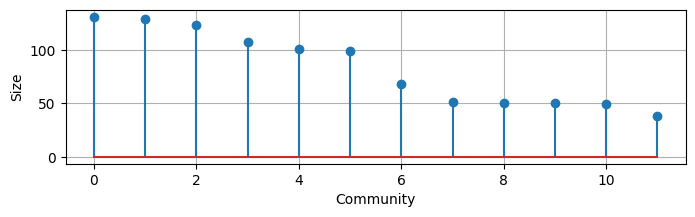

In [ ]:
# Sort communities by decreasing size
C = sorted(C, key=len, reverse=True)
# Number of communities
nc = len(C)

# Size of each community
comm_sizes = [len(x) for x in C]

plt.figure(figsize=(8, 2))
plt.stem(range(nc), comm_sizes)
plt.xlabel('Community')
plt.ylabel('Size')
plt.grid('on')
plt.show()

Now, lets plot the comunities over the graph using node coloring. To do so, we need a palette of RGB colors

In [ ]:
# Get a palette of rgb colors as large as the list of unique attributes
palette = sns.color_palette(palette="Paired", n_colors=nc)
# WARNING: The command  below should show an image with the colors of the
#          palette, but it might not work in Google Colab. You can simply
#.         ignore it in such a case
palette

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

Communities are defined in variable `C`, which a list of sets, one per community. We need a dictionary to map nodes to communities:

In [ ]:
# Mapping communities in nx format into an ordered list of communities, one per node.
node2comm = {n: 0 for n in G_lcc}
for i, com in enumerate(C):
    for node in list(com):
        node2comm[node] = i

We are almost ready to plot the colored graph where each node gets the color of its community. Also, we will make the size of the nodes proportional to the degree (number of neighbors) of the node. We need variables `palette` and `note2comm` to generate the list of node colors.

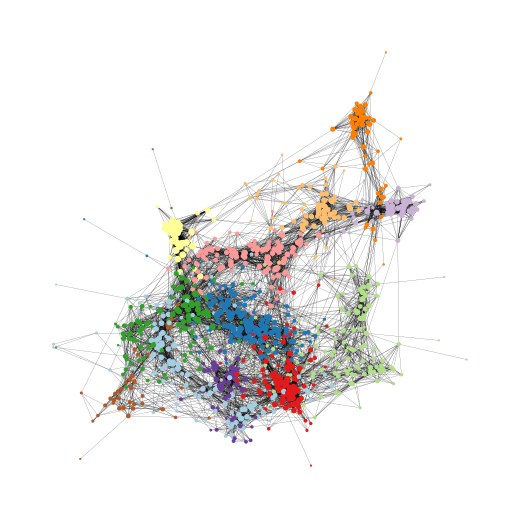

In [ ]:
# Map node attribute to rgb colors
node_colors = [palette[node2comm[n]] for n in G_lcc]

# Get list of degrees
degrees = [val / 3 for (node, val) in G_lcc.degree()]

#  Draw graph
plt.figure(figsize=(5, 5))
nx.draw(G_lcc, positions, node_size=degrees, node_color=node_colors, width=0.1)

### 4.4. Quality metrics

The quality of a partition may depend on the application. However, some generic quality measures can be useful to check if the partition has the desired properties of large intra-community connectivity and small inter-community connectivity.

The modularity is one such measure. The following are two other alternatives

 * **Coverage**: the ratio of the number of intra-community edges to the total number of edges in the graph.
 * **Performance**: the number of intra-community edges plus inter-community non-edges divided by the total number of potential edges.

 Both of them take values in $[0, 1]$.

**Exercise 10**: Use the `partition_quality` method from `nx_comm` to compute the coverage and performance of the Louvain partition.


In [ ]:
coverage, performance = nx_comm.partition_quality(G_lcc, C)

print(f"Coverage: {coverage}")
print(f"Performance: {performance}")

Coverage: 0.8837
Performance: 0.9191661116829125


### 4.5. Community analysis

Once we have identified the communities, we can use the textual information about documents to characterize each one of them. Since our source dataframe contains a keyword assigned to each topic (in column `main_topic_35`), we can assign the most frequent keywords to each community:

In [ ]:
col = 'main_topic_35'
newcols=['Community', 'Main topic', 'Topic 2', 'Topic 3', 'Topic 4']

df = pd.DataFrame(columns=newcols).set_index('Community')

# For each community...
for i, docs in enumerate(C):

    # Join all keywords from all documents in the community
    words = ",".join(NSF_df.iloc[list(docs)][col]).split(",")

    # Count the number of occurences of each keyword
    kwd_count = Counter(words)
    n_votes = sum(kwd_count.values())

    # Keep keywords that are frequent enough
    kwds = [k for k, v in kwd_count.items() if v > 0.12 * n_votes]
    kwds = sorted(kwds, key= lambda x: kwd_count[x], reverse=True)
    kwds = [f'C{i}'] + kwds + [""] * (len(newcols) - len(kwds) -1)

    row = pd.Series(dict(zip(newcols, kwds))).to_frame().T.set_index('Community')
    df = pd.concat([df, row], axis=0)

df

,Main topic,Topic 2,Topic 3,Topic 4
Community,,,,
C0,Genetics,Chemistry,,
C1,Computer Science,Cloud Computing,Wireless Communications,Internet
C2,Quantum Physics,Material Engineering and production,Electronics and Optics,
C3,Machine Learning,Robotics,,
C4,Environment,biodiversity,Biological Evolution,
C5,Learning and Teaching technologies,Urban projects for local communities,,
C6,Climate change,Fluid Physics,Sustainability,Environment
C7,Astrophysics,Particle physics,,
C8,Geology,Disaster Prevention and Control,,


The table shows the dominant topic keywords in each community. It is interesting to see how some related topics have been clustered into the same community.

We may wonder if we can identify semantic connections between communities by analyzing the graph, and the edges connecting nodes from different communities. To do so, we will build a graph of communities.

### 4.6 Community networks

---
**Exercise 11**:

Compute a matrix of inter-community similarities, ${\bf M}$, such that $M_{ij}$ is the similarity between communities $i$ and $j$, computed as
$$
M_{ij} = \frac{1}{|{\cal C}_i|\cdot|{\cal C}_j|}\sum_{m \in {\cal C}_i} \sum_{n \in {\cal C}_j} S_{ij}
$$
where ${\cal C}_i$ is the set of nodes from community $i$ and $|{\cal C}_i|$ is its cardinality.

Since `S` is upper triangular, you can use matrix `S2` below to get the symmetric form. It is converted to `sparse.csr` format to allow indexing.

In [ ]:
import scipy.sparse as scsp

# Convert matrix to csr (otherwise, it cannot be indexed)
S2 = scsp.csr_matrix(S + S.T)

# Initialize matrix for the community graph
M = np.zeros((nc, nc))

# Loop over the communities
for i in range(nc):
    nodes_i = list(C[i])
    ni = len(nodes_i)

    # Loop over the communities
    for j in range(i+1, nc):
        nodes_j = list(C[j])
        nj = len(nodes_j)

        # Select submatrix Sij, with rows from Ci and columns from Cj
        Sij = S2[nodes_i][:, nodes_j]

        # Compute Mij
        M[i, j] = np.sum(Sij) / (ni * nj)

# Make the matrix symmetric
M = M + M.T
# Print the resulting matrix
print("Community Similarity Matrix:")
print(M)

Community Similarity Matrix:
[[0.00000000e+00 2.85630578e-04 4.34914061e-03 6.43444716e-04
  3.33994172e-03 7.74140603e-04 6.18959756e-04 0.00000000e+00
  0.00000000e+00 1.01353968e-04 0.00000000e+00 3.42405722e-03]
 [2.85630578e-04 0.00000000e+00 1.02719779e-03 9.89656230e-03
  0.00000000e+00 4.83289362e-03 7.62904942e-05 0.00000000e+00
  3.11435304e-04 1.53031800e-03 2.10968409e-03 0.00000000e+00]
 [4.34914061e-03 1.02719779e-03 0.00000000e+00 6.81586357e-04
  5.30386260e-05 5.73891766e-04 4.44742672e-04 1.40589319e-03
  3.34701957e-04 1.07250101e-04 6.98986900e-04 1.08042396e-03]
 [6.43444716e-04 9.89656230e-03 6.81586357e-04 0.00000000e+00
  6.14178737e-05 1.66346027e-03 8.67742418e-04 0.00000000e+00
  3.97467996e-04 5.60913493e-03 1.20693572e-02 4.74109179e-03]
 [3.33994172e-03 0.00000000e+00 5.30386260e-05 6.14178737e-05
  0.00000000e+00 2.88101105e-03 8.36754958e-03 0.00000000e+00
  2.41421365e-03 2.47293369e-03 0.00000000e+00 3.72458312e-03]
 [7.74140603e-04 4.83289362e-03 5.73

---
**Exercise 12**: Generate a graph of communities, `CG`, using matrix ${\bf M}$, and compute the layout positions using the FR algorithm.



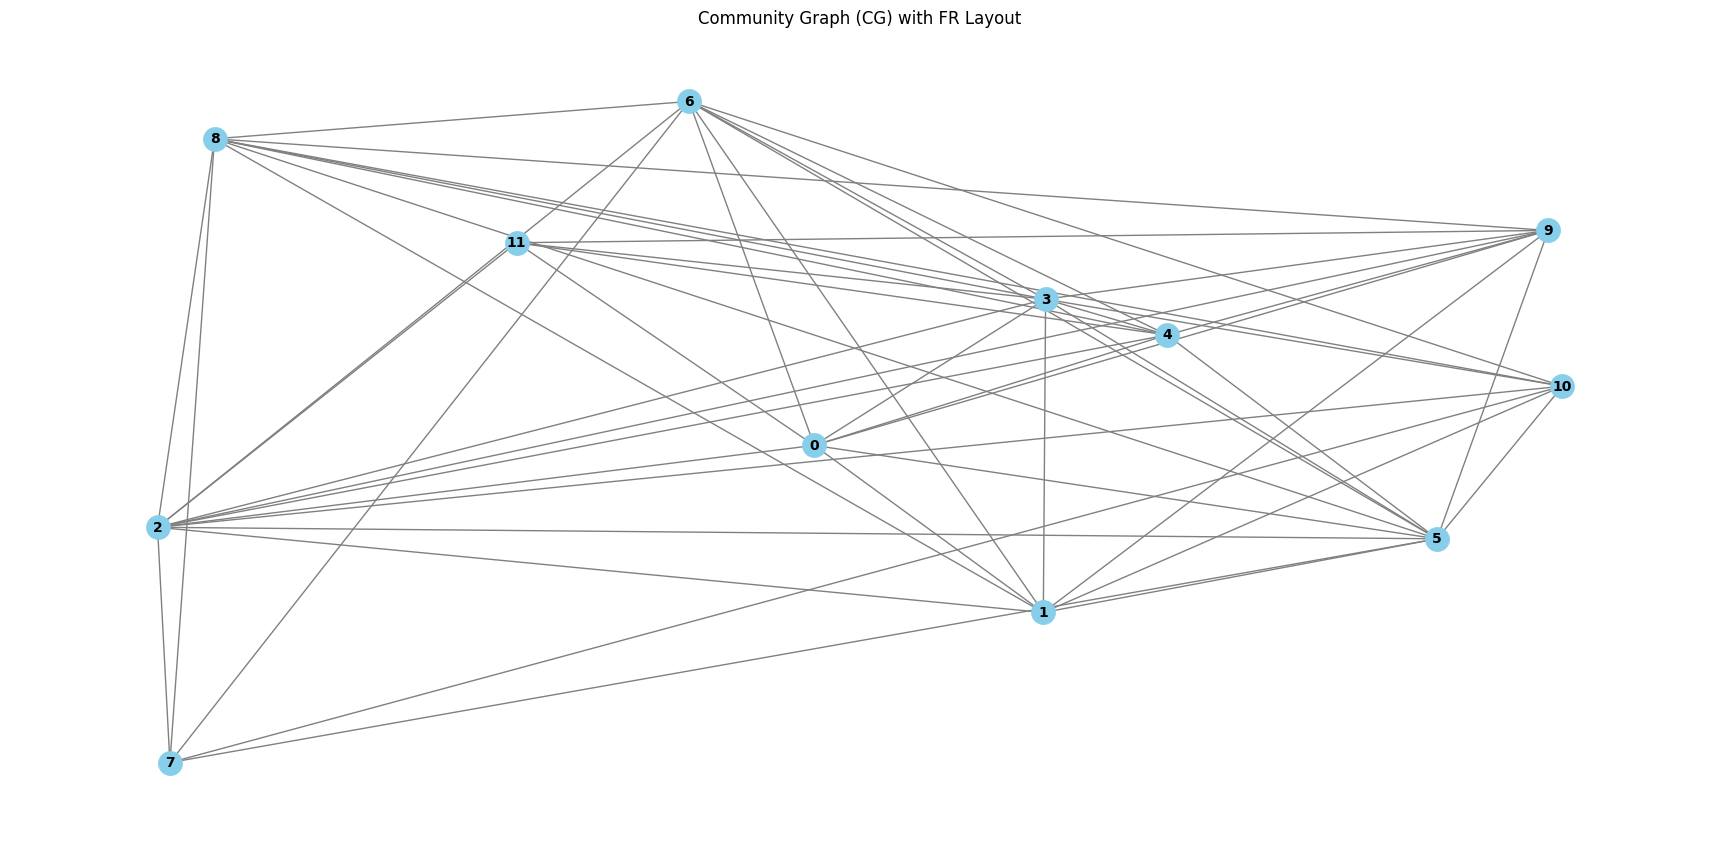

In [ ]:
# Graph of communities
# <SOL>
CG = nx.from_numpy_array(M)
positions_CG = nx.spring_layout(CG, seed=0)
plt.figure(figsize=(17, 8))
nx.draw(CG, pos=positions_CG, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5)
plt.title("Community Graph (CG) with FR Layout")
plt.show()
# </SOL>

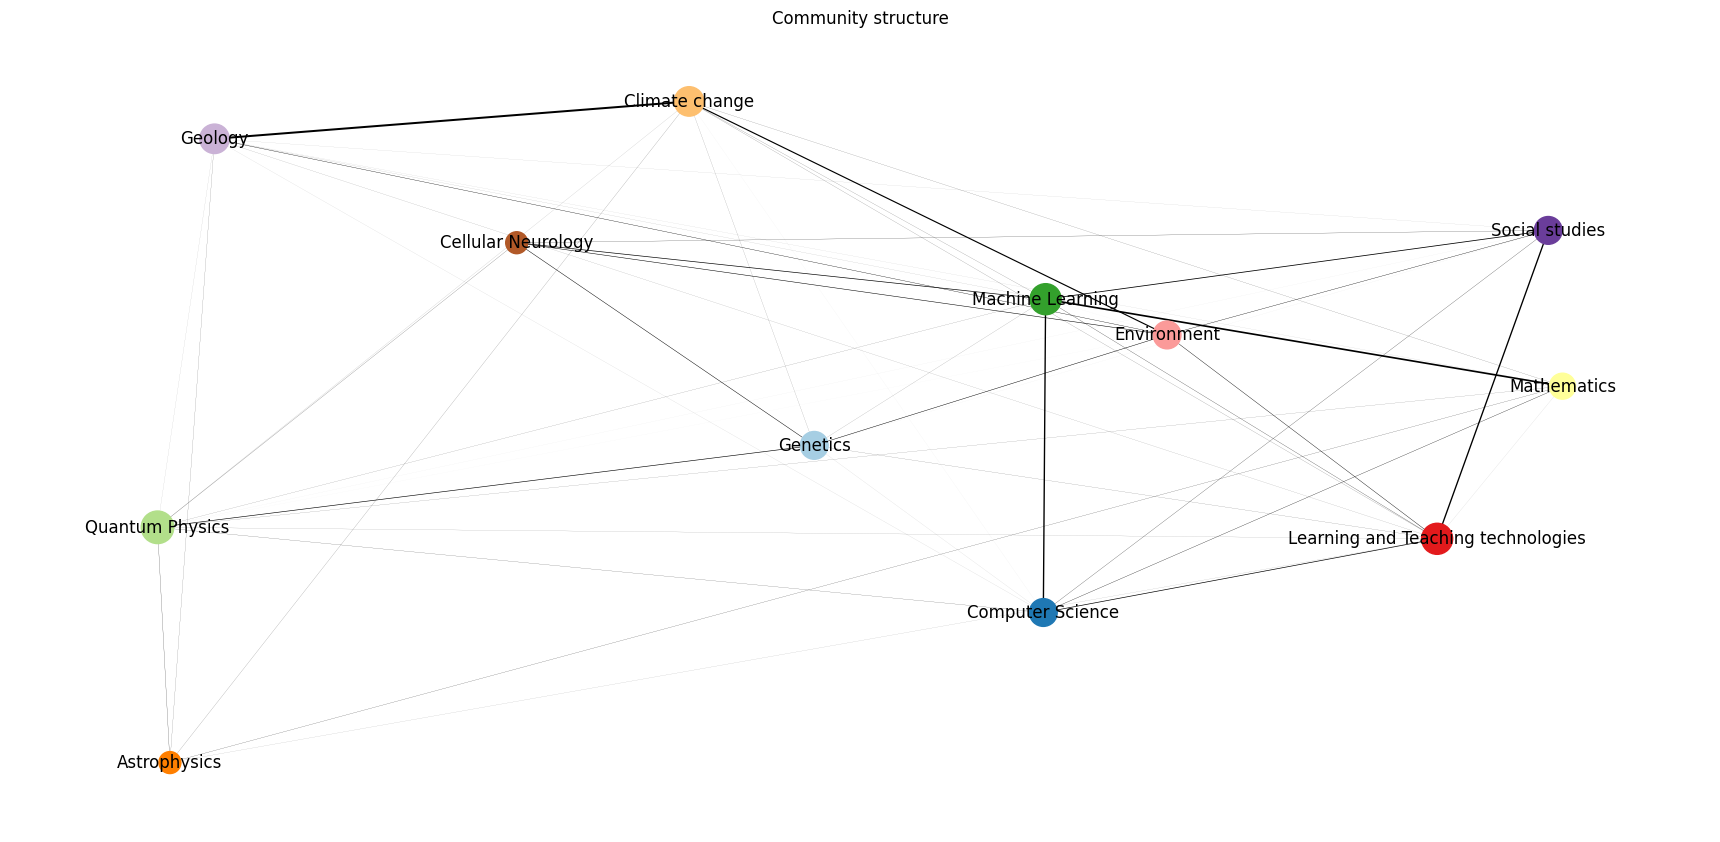

In [ ]:
# Compute edge widths

# A la hora de dibujar el grafo, le asigno a cada comunidad el main topic, es decir, el tópico más representativo de la comunidad
# De este modo en la visualización se podrá analizar mucho mejor si el grafo captura bien las relaciones semánticas entre tópicos
node_labels = {i: df.loc[f'C{i}', 'Main topic'] for i in range(nc)}

w = [e[2]['weight'] * 100 for e in CG.edges(data=True)]
# Compute node sizes
degrees = [val * 50 for (node, val) in CG.degree()]

plt.figure(figsize=(17,8))
nx.draw(CG, positions_CG, node_size=degrees, width=w, node_color=palette, with_labels=True, labels= node_labels)
plt.title("Community structure")
plt.show()

---
**Exercise 13**: Analyze the community graph. Has it identified the semantic relations that could be expected from he topic labels?


# **Ejercicio 13**

En el grafo anterior se ha tomado la decisión de mostrar en cada nodo el main topic asociado a esa comunidad. Como se puede observar, el grafo guarda cierta coherencia. Entre elementos relacionados con la IA, como "Machine Learning", "Mathematics", "Learning and Teaching Technologies", "Computer Science" y "Language Technologies" existen fuertes conexiones entre los nodos. De este mismo modo ocurre con comunidades relacionadas con las ciencias ambientales como "Geology", "Climate Change", "Environment", "Sustainability", "Genetics", y "Cellular Neurology".

Además, uno de los tópicos que guardan menor relación con el resto,"Astrophysics", presenta conexiones de poco peso con la mayoría de los temas con los que está conectado, y además, su nodo está especialmente alejado del resto. Su conexión más fuerte se da con el tópico "Mathematics", lo cual es un resultado coherente ya que la Astrofísica es un tema bastante relacionado con las Matemáticas.

La disposición espacial de los nodos (comunidades) del grafo, así como sus conexiones con el resto son bastante coherentes y llevan a pensar que el grafo de comunidades ha conseguido captar correctamente las relaciones semánticas entre los diferentes temas del corpus.

## 5. Impact

Community detection algorithms provide information about the overall structure of the document collection. In this section we will explore measures to evaluate the role of a node in its network, using a family of **centrality** measures, that evaluate nodes according to their position in the graph.

NetworkX contains methods to compute several [centrality](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) measures. Here, we wil review some of them.

### 5.1. Degree centrality.

This is one of the simplest measures of the relevance of a node in a graph. The degree of a node in an unweighted graph is the number of its neighbours. For a weighted graph, it is the sum of its edge weights. For a graph with $N$ nodes:
$$
\text{degree}(n) = \sum_{i=0}^{N-1} S_{ni}
$$


---
**Exercise 14**: Compute the degree centrality of all nodes in graph `G_lcc`.

Print the sum of all centrality values. Can you relate it to the sum of all graph weights?

In [ ]:
# Compute centrality
centrality = dict(G_lcc.degree(weight='weight'))
print(type(centrality))
# Print the sum of all centrality values:
# <SOL>
sum_centrality = sum(centrality.values())
print("Sum of centrality: ", sum_centrality)

sum_weights = sum(nx.get_edge_attributes(G_lcc, 'weight').values())
print("Sum of Graph Weights: ", sum_weights)
print("Double of sum of Graph Weights: ", 2.0*sum_weights)

<class 'dict'>
Sum of centrality:  15045.319384132508
Sum of Graph Weights:  7522.659692066237
Double of sum of Graph Weights:  15045.319384132474


Como se puede observar en la salida de la celda anterior, la suma de la centralidad se corresponde con el doble de la suma de los pesos del grafo. En este caso, es el doble puesto que la matriz de centralidad es simétrica.
Si se suman los valores de una fila de la matriz de centralidad, se obtiene el valor de centralidad de un nodo concreto (el i-ésimo, suponiendo que se suman los valores de la fila i).
Al sumar todas las filas, se obtiene el valor de centralidad de todos los nodos del grafo. Como se ha mencionado anteriormente, al trabajar con una matriz simétrica (lo cual no es necesario), el resultado de la suma de pesos es el doble de la centralidad.

We can highlight, over the graph, the top 3 nodes with the highest centrality:

38.326096471431605


,title,main_topic_35
34672,Random Structures and Algorithms,Mathematics
13934,Higher genus categorical Gromov-Witten invariants,Mathematics
35092,Analytic and Algebraic Methods in Discrete Geo...,Mathematics


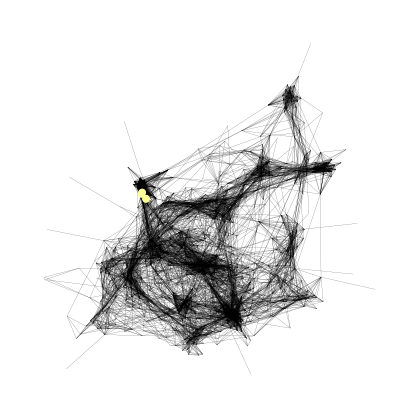

In [ ]:
# Compute top 3 nodes
sorted_ctr = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
ctr_top3 = sorted_ctr[2][1]
print(ctr_top3)

# Highlight top nodes with a larger node size
eps = 1e-5
node_sizes = [20 * x[1] / ctr_top3 * (x[1] > ctr_top3 - eps) for x in centrality.items()]

# Plot graph
plt.figure(figsize=(4, 4))
nx.draw(G_lcc, positions, node_size=node_sizes, node_color=node_colors, width=0.1)

# Print top 3 nodes
top3_nodes = [x[0] for x in sorted_ctr[:3]]
df_best = NSF_df.iloc[top3_nodes][['title', 'main_topic_35']]
df_best

Note that the top 3 nodes belong to the same cluster: a region with densely connected nodes.

### 5.2. Closeness

The closeness centrality is defined as the average lentgh of the shortest path from the node to all other reachable nodes in the graph (i.e. all nodes in the same connected component).

To compute the centrality, a distance between edges must be defined. For unweighted graphs, a unit distance is taken for all edges. However, if the similarity measures has been defined from a distance through an exponential transformation
$$
s = \exp(- d)
$$
then $-\log(s)$ is the natural choice for the distance.

We have computed the similarity values using the BC, which has not been obtained through an exponential transformation. Fortunately, it can be shown that the measure given by
$$
d({\bf x}, {\bf y}) = 1 - s_{\rm BC}({\bf x}, {\bf y})
$$
is a distance known as the **Hellinger distance**. Thus, we will use this transformation.



---
**Exercise 15**: Compute the closenes centrality of the nodes in `G_lcc` using the Hellinger distance. To do so:

  * Get the dictionary of edges and weights from `G_lcc` [get_edge_attributes](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_edge_attributes.html)
  * Make a dictionary with edges as keys and values with the format `{'distance': d}` where `d` is the Hellinger distance, computed from the similarity value (the edge weight).
  * Add the `distance` attibute to the graph using the [set_edge_attributes](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_edge_attributes.html) method.
  * Compute the closeness centrality using the [closenes_centrality](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.closeness_centrality.html) method, and taking `distance` as the distance metric.

In [ ]:
edges = nx.get_edge_attributes(G_lcc, "weight")
hellinger_distances = {}
for edge in edges.keys():
  hellinger_distances[edge] = 1 - S.tocsr()[edge[0], edge[1]]



# Add distance attribute
# <SOL>
nx.set_edge_attributes(G_lcc, hellinger_distances, "distance")
# </SOL>

# Compute centrality
centrality = nx.closeness_centrality(G_lcc, distance='distance')

As before, we can print and visualize the top 3 nodes in the graph

,title,main_topic_35
26976,"RUI: Partially Observed Curves, and Big-Data V...",Machine Learning
26381,Statistical Learning Problems with Complex Sto...,Machine Learning
20490,CAREER: Advancing Constrained and Non-Convex L...,Machine Learning


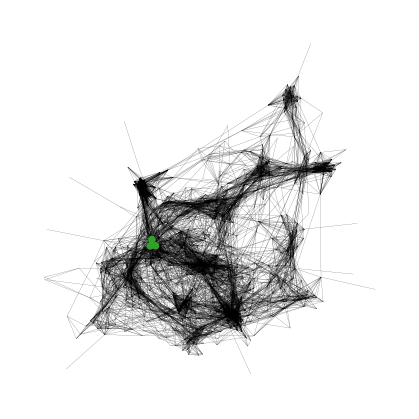

In [ ]:
# Compute top 3 nodes
sorted_ctr = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
ctr_top3 = sorted_ctr[2][1]

# Highlight top nodes with a larger node size
eps = 1e-5
node_sizes = [20 * x[1] / ctr_top3 * (x[1] > ctr_top3 - eps) for x in centrality.items()]

# Plot graph
plt.figure(figsize=(4, 4))
nx.draw(G_lcc, positions, node_size=node_sizes, node_color=node_colors, width=0.1)

# Print top 3 nodes
top3_nodes = [x[0] for x in sorted_ctr[:3]]
df_best = NSF_df.iloc[top3_nodes][['title', 'main_topic_35']]
df_best

---
**Exercise 16**: Discuss the above result. What is/are the topic/s of the nodes with the highest closeness? Can you guess an explanation to the presence of this topic in these nodes?



Los tres nodos con mayor cercanía son:



*   "**RUI: Partially Observed Curves, and Big-Data Virtual Bootstrap**"
*   "**Statistical Learning Problems with Complex Stochastic Models**"
*   "**CAREER: Advancing Constrained and Non-Convex Learning**"


El tópico de estos tres nodos (documentos) con mayor cercanía es común: "Machine Learning". Este es un resultado bastante razonable teniendo en cuenta el contenido de cada documento, puesto que todos tratan sobre subcampos dentro del Machine Learning y el Machine Learning es un tópico extremadamente común en el corpus.
Dado que los documentos del tópico de Machine Learning guardan altos grados de similaridad con el resto de documentos, y teniendo en cuenta la fórmula de la "hellinger distance" d(x,y)=1−sBC(x,y), a  mayor similaridad entre documentos, menor distancia habrá entre los nodos. De este modo, los resultados obtenidos (sabiendo que Machine Learning es un tópico muy relacionado con el resto) parecen razonables.



### 5.3. Betweenness

The betweenness centrality of a node $n$ is defined as the number of shortest paths between any pair of nodes in the graph that pass through $n$.

---
**Exercise 17**: Using the [betweenness_centrality](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html) method, compute the betweenness centrality of the nodes in `G_lcc` using the distance attribute as the weight argument.

In [ ]:
# Compute centrality
centrality = nx.betweenness_centrality(G_lcc, weight='distance', seed=0)

,title,main_topic_35
19913,EAGER: A Framework for Learning Graph Algorith...,Machine Learning
27242,Collaborative Research: From Loading to Ruptur...,Geology
4655,SPX: Scalable In-Memory Processing Using Spint...,"Computer Science, Cloud Computing"


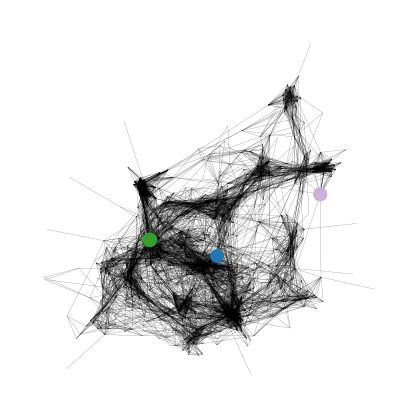

In [ ]:
# Compute top 3 nodes
sorted_ctr = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
ctr_top3 = sorted_ctr[2][1]

# Highlight top nodes with a larger node size
eps = 1e-5
node_sizes = [80 * x[1] / ctr_top3 * (x[1] > ctr_top3 - eps) for x in centrality.items()]

# Plot graph
plt.figure(figsize=(4, 4))
nx.draw(G_lcc, positions, node_size=node_sizes, node_color=node_colors, width=0.1)

# Print top 3 noder
top3_nodes = [x[0] for x in sorted_ctr[:3]]
## df_best = NSF_df.iloc[id_best_nodes][['title', 'year', 'clean_lemmas', 'main_topic_35']]
df_best = NSF_df.iloc[top3_nodes][['title', 'main_topic_35']]
df_best

### 5.4. PageRank

[PageRank](https://en.wikipedia.org/wiki/PageRank) (PR) belongs to a family of [**eigenvector** centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality) measures. It was proposed by Larry Page and Serguéi Brin as a method to rank Internet pages for the Google search engine [[Page, 1998](http://infolab.stanford.edu/pub/papers/google.pdf)].

Let us assume that, starting form node $n$, we perform a random walk through the graph, jumping from each node to any of the neighbour nodes with probabilities in proportion to the graph weights. With some probability $d$ (which is a free parameter of the measure) we jump back to the original node. PR accounts for the expected frequencies of visiting a given node through this walk.

It turns out that the visiting probabilities can be expressed recursively as
$$
{\rm PR}(n) = (1-d) + d \sum_{i \in {\cal N}(n)} \frac{{\rm PR}(i)}{C_i}
$$
where
  * ${\rm PR}(n)$ is the PageRank of  node $n$.
  * ${\cal N}(n)$ is the set of neighbors from node $n$.
  * $d \in [0,1]$ is the *dumping factor*.
  * $C_i$ is the out-degree of node $i$. For weighted and undirected graphs, it is the sum of all edge weights at node $i$.

---
**Exercise 18**: Using the [pagerank](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html) method, compute the PageRank of the nodes in `G_lcc`.

In [ ]:
centrality = nx.pagerank(G_lcc, tol=1e-06, nstart=None, weight='weight', dangling=None)

,title,main_topic_35
21596,CRII: CIF: Unifying Scheduling and Optimizatio...,Machine Learning
29806,Collaborative Research: Sequence Selective Rec...,Genetics
28072,Collaborative Research: Reconstructing Domesti...,"Environment, biodiversity"


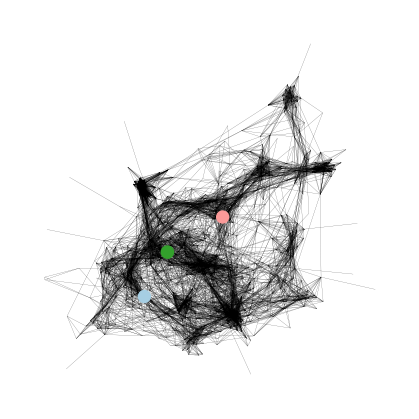

In [ ]:
sorted_ctr = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
ctr_top3 = sorted_ctr[2][1]
top3_nodes = [x[0] for x in sorted_ctr[:3]]

node_sizes = [40000 * x * (x > 0.00184) for x in centrality.values()]
plt.figure(figsize=(4,4))
nx.draw(G_lcc, positions, node_size=node_sizes, node_color=node_colors, width=0.1)

sorted_pr = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:3]
id_best_nodes = [x[0] for x in sorted_pr]
df_best = NSF_df.iloc[top3_nodes][['title', 'main_topic_35']]
df_best

## References

  * Jacomy, M., Venturini, T., Heymann, S., & Bastian, M. (2014). [ForceAtlas2, a continuous graph layout algorithm for handy network visualization designed for the Gephi software](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0098679#s2). PloS one, 9(6), e98679.
  * Brin, S. Page, L. (1998). "[The anatomy of a large-scale hypertextual Web search engine](http://infolab.stanford.edu/pub/papers/google.pdf)". Computer Networks and ISDN Systems. 30 (1–7):